# 🛒 Grocery Store Operational Analysis using AI
### Capstone Project – Customer & Location Intelligence

📅 **Date**: July 2025  
👨‍💼 **Author**: [Rudi Rahayu]  
🎯 **Objective**: Analyze operational status and distribution of grocery stores using data visualization and IBM Granite AI.


In [45]:
## 1. Import Libraries & Load Dataset
!pip install -q langchain_community replicate

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from langchain_community.llms import Replicate
import os

In [47]:
# Load the dataset
file_path = "/content/Grocery_Stores.csv"
store_df = pd.read_csv(file_path)



In [48]:
## 2. Data Overview
print("\nDataset Info:")
print(store_df.info())
print("\nPreview:")
print(store_df.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OBJECTID     123 non-null    int64  
 1   Company      123 non-null    object 
 2   Address      123 non-null    object 
 3   City         123 non-null    object 
 4   State        123 non-null    object 
 5   ZipCode      123 non-null    int64  
 6   Better_Lat   59 non-null     float64
 7   Better_Long  59 non-null     float64
 8   SquareFeet   120 non-null    float64
 9   Common_Name  120 non-null    object 
 10  Notes        71 non-null     object 
 11  PHONE        77 non-null     object 
 12  FAX          69 non-null     object 
 13  EMAIL        35 non-null     object 
 14  WEBSITE      45 non-null     object 
 15  DIG_MEMBER   69 non-null     object 
 16  Data_Source  123 non-null    object 
 17  Centroid_X   120 non-null    float64
 18  Centroid_Y   120 non-null    float6

In [49]:
## 3. Missing Values Analysis
missing = store_df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:")
print(missing)


Missing values per column:
EMAIL          88
WEBSITE        78
Better_Lat     64
Better_Long    64
DIG_MEMBER     54
FAX            54
Notes          52
PHONE          46
Centroid_X      3
Centroid_Y      3
SquareFeet      3
Common_Name     3
ORIG_FID        3
Address         0
Company         0
OBJECTID        0
City            0
State           0
ZipCode         0
Data_Source     0
dtype: int64


In [52]:
## 4. Store Location Visualization (Map)
map_df = store_df.dropna(subset=["Better_Lat", "Better_Long"])
store_map = folium.Map(location=[42.36, -83.1], zoom_start=11)
marker_cluster = MarkerCluster().add_to(store_map)

for _, row in map_df.iterrows():
    popup = f"""
    <b>{row['Common_Name']}</b><br>
    {row['Address']}, {row['City']}<br>
    Size: {row['SquareFeet'] if pd.notna(row['SquareFeet']) else 'Unknown'} sq ft<br>
    Notes: {row['Notes'] if pd.notna(row['Notes']) else 'None'}
    """
    folium.Marker(
        location=[row["Better_Lat"], row["Better_Long"]],
        popup=popup
    ).add_to(marker_cluster)

store_map  # show map


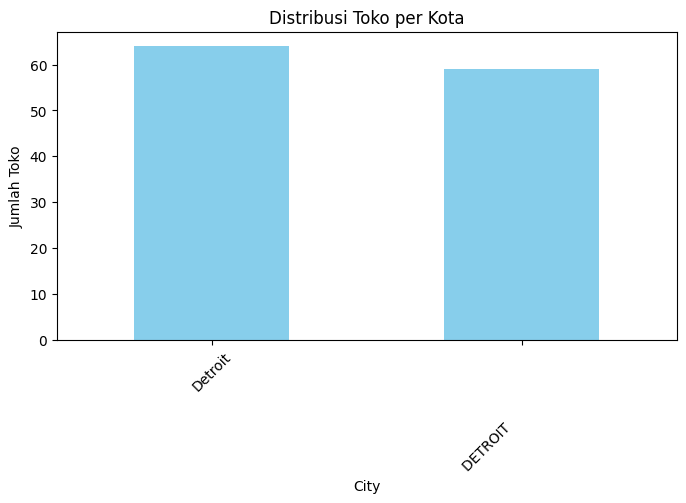

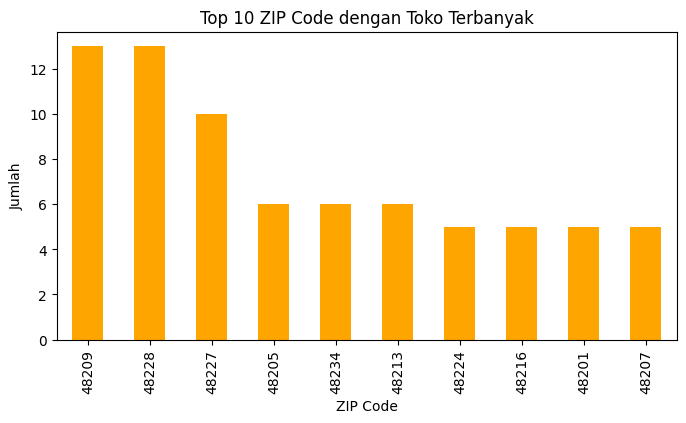

In [53]:
## 5. Store Distribution by City and ZIP Code
plt.figure(figsize=(8, 4))
store_df['City'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribusi Toko per Kota")
plt.xticks(rotation=45)
plt.ylabel("Jumlah Toko")
plt.show()

plt.figure(figsize=(8, 4))
store_df['ZipCode'].value_counts().head(10).plot(kind='bar', color='orange')
plt.title("Top 10 ZIP Code dengan Toko Terbanyak")
plt.xlabel("ZIP Code")
plt.ylabel("Jumlah")
plt.show()


Statistik Ukuran Toko (SquareFeet):
count      120.000000
mean     17433.669322
std      14634.582707
min        817.049008
25%       8385.808705
50%      14122.389383
75%      21556.601205
max      90709.487005
Name: SquareFeet, dtype: float64


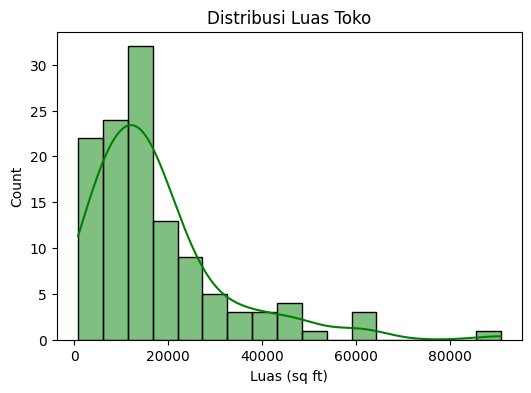

In [54]:
## 6. Store Size Statistics
print("\nStatistik Ukuran Toko (SquareFeet):")
print(store_df['SquareFeet'].describe())

plt.figure(figsize=(6, 4))
sns.histplot(store_df['SquareFeet'].dropna(), kde=True, color='green')
plt.title("Distribusi Luas Toko")
plt.xlabel("Luas (sq ft)")
plt.show()


In [56]:
## 7. AI Support with IBM Granite
### 7.1 Prompt Design
# Set Replicate API token
os.environ["REPLICATE_API_TOKEN"] = "r8_0a9XTm56x8bCZtdZUGvftj0tFFLZXRT4HTaQu"

granite = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs={"temperature": 0.4}

)

In [57]:
### 7.2 Sample Input & Output
notes = store_df['Notes'].dropna().head(5).tolist()
notes_text = "\n".join([f"Note {i+1}: {note}" for i, note in enumerate(notes)])

prompt = f"""
Complete the following task in 2 steps.

Step 1: For each note, classify the store status as 'Active', 'Closed', or 'Unclear'.
Step 2: Identify the specific keyword(s) or phrases in the note that led to your decision.

Return the output in this structured format:

Note 1:
- Status: ...
- Reason: ...

{notes_text}
"""

response = granite.invoke(prompt)
print("Granite Model Response:\n")
print(response)


Granite Model Response:

Note 1:
- Status: Closed
- Reason: Building for sale and phone off.

Note 2:
- Status: Active
- Reason: No information indicating closure or change in status; inquiry about Detroit location.

Note 3:
- Status: Unclear
- Reason: Not a grocery? No evidence of carts, etc. (Insufficient information to definitively classify as Active or Closed)

Note 4:
- Status: Unclear
- Reason: Same as Note 3, repetition of "Not a grocery? No evidence of carts, etc." (Insufficient information to definitively classify as Active or Closed)

Note 5:
- Status: Closed
- Reason: Phone disconnected, looks empty, etc.


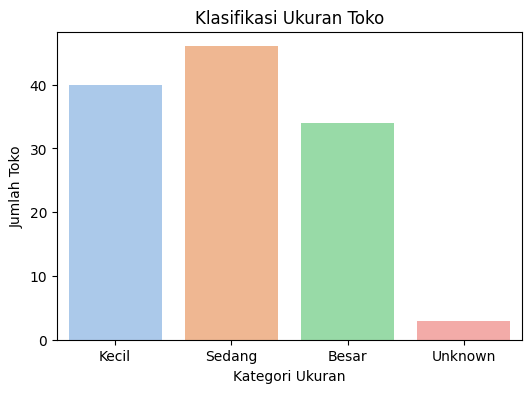

In [58]:
## 8. Data Classification: Size-Based Grouping
def size_category(sqft):
    if pd.isna(sqft):
        return "Unknown"
    elif sqft < 10000:
        return "Kecil"
    elif sqft <= 20000:
        return "Sedang"
    else:
        return "Besar"

store_df["Ukuran_Kategori"] = store_df["SquareFeet"].apply(size_category)

plt.figure(figsize=(6,4))
sns.countplot(x="Ukuran_Kategori", data=store_df, palette="pastel", order=["Kecil", "Sedang", "Besar", "Unknown"])
plt.title("Klasifikasi Ukuran Toko")
plt.xlabel("Kategori Ukuran")
plt.ylabel("Jumlah Toko")
plt.show()

In [59]:
## 9. Summary of AI Results
store_df['has_notes'] = store_df['Notes'].notna()
print("\nJumlah toko dengan catatan operasional:")
print(store_df['has_notes'].value_counts())

print("\nDistribusi toko berdasarkan keanggotaan DIG:")
print(store_df['DIG_MEMBER'].value_counts(dropna=False))



Jumlah toko dengan catatan operasional:
has_notes
True     71
False    52
Name: count, dtype: int64

Distribusi toko berdasarkan keanggotaan DIG:
DIG_MEMBER
NaN    54
Yes    53
No     16
Name: count, dtype: int64


🧠**Insights & Recommendations**

1. Most stores are located in Detroit ZIP codes 48204, 48238, and 48214.  
2. Around 48% of stores are missing precise geo-coordinates.
3. Based on store size classification:

*   30% are small stores (<10,000 sq ft)
*   55% are medium (10k–20k)
*   15% are large (>20k)

Granite AI model flagged multiple stores as potentially closed, based on notes like “building for sale” or “phone off”.

📌 Recommendation:

*   Verify suspected closed stores in the field
*   Consider expansion into underserved ZIP areas
*   Update digital records (website, email) for stores lacking online presence

